In [1]:
from sklearn.datasets import load_breast_cancer  # 데이터셋 로드
from sklearn.model_selection import train_test_split  # 훈련셋이랑 검증셋 분리

cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
# 데이터 분할
x_train_all, x_test, y_train_all, y_test = train_test_split(x,y, stratify=y, test_size=0.2, random_state=42)

# 트레인 셋이랑 데이터 셋을 다시 차례로 분리하기
x_train , x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)
print(len(x_train), len(x_val))  # val : validation set


364 91


In [2]:
print(x_train.shape,x_val.shape)

(364, 30) (91, 30)


# 정방향 계산을 행렬 곱셈으로 표현하기

dot을 사용해서 행렬곱셈을 할 수 있다.

In [0]:
from sklearn.linear_model import SGDClassifier
import numpy as np
import matplotlib.pyplot as plt

In [0]:
class SingleLayer_l1l2:
    def __init__(self, learning_rate=0.1, l1=0, l2=0):
        self.w = None  # weight 가중치
        self.b = None  # bias 바이어스
        self.losses = []  # 손실을 누적
        self.val_losses = [] # 검증 셋에 대한 손실을 기록
        self.w_history = []  # 가중치 변화 누적하는 리스트
        self.lr = learning_rate  # 학습률(hyperparameter)
        self.l1 = l1
        self.l2 = l2

    def forpass(self, x):
        # 정방향 진행에 행렬곱 사용
        z = np.dot(x, self.w) + self.b
        return z

    def backprop(self, x, error):
        # 역방향 진행에 전치행렬곱을 적용
        w_g = np.dot(x.T, error) / len(x)  #평균 그레이디언트라서!
        b_g = np.sum(error) / len(x)
        return w_g, b_g

    def add_bias(self, x):
        # 1로 채워진 열백터를 추가하는. 
        return np.c_[np.ones((x.shape[0], 1)), x]

    def activation(self, z):
        # 활성화 함수
        a = 1 / (1 + np.exp(-z))
        return a 

    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        # 전체 샘플을 한 번에 계산하기 때문에 약간의 수정이 가해진다
        # 가중치랑 바이어스를 초기화
        y = y.reshape(-1,1)  # 타깃을 열백터로 바꾼다 (1; 1; 1...)
        y_val = y_val.reshape(-1,1)  # 검증용 타겟도 열백터로 바꾸기
        m = len(x)
        self.w = np.ones((x.shape[1],1))  # w, b 초기화
        self.b = 0
        self.w_history.append(self.w.copy())  # 가중치 기록
        for i in range(epochs):
            # 에포크만큼 반복
            z = self.forpass(x)
            a = self.activation(z)
            err = -(y -a)  # 오차 계산
            w_grad, b_grad = self.backprop(x, err)  # 오차 역전파로 그라디언트 계산 후 빼줘야 한다. 
            w_grad += (self.l1* np.sign(self.w) + self.l2*self.w) / m  # 페널티의 미분값을 더해준다, 규제
            self.w -= self.lr * w_grad  # 가중치와 절편 업데이트
            self.b -= self.lr * b_grad
            self.w_history.append(self.w.copy())
            a = np.clip(a, 1e-10, 1-1e-10)
            loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
            self.losses.append((loss + self.reg_loss()) / m)
            self.updata_val_loss(x_val, y_val)

    def reg_loss(self):
        # 페널티 항에 대한 값을 더해야 한다. (규제 적용)
        return self.l1*np.sum(np.abs(self.w)) + self.l2/2 * np.sum(self.w**2)

    def updata_val_loss(self, x_val, y_val):
        z = self.forpass(x_val)
        a = self.activation(z)
        a = np.clip(a, 1e-10, 1-1e-10)
        val_loss = np.sum(-(y_val*np.log(a) + (1-y_val)*np.log(1-a)))
        self.val_losses.append((val_loss + self.reg_loss())/ len(y_val))  # 로그 손실과 규제 손실을 더해서 리스트에 추가

    def predict(self, x):
        z = self.forpass(x)
        return z > 0

    def score(self, x, y):
        return np.mean(self.predict(x)==y.reshape(-1,1))

# 훈련 데이터 표준화 전처리하기

In [0]:
from sklearn.preprocessing import StandardScaler

In [0]:
scaler = StandardScaler()
scaler.fit(x_train)  # x train으로 fit하고
x_train_scaled = scaler.transform(x_train)  # fit로 구한 표준편차를 x train으로 표준화시키기
x_val_scaled = scaler.transform(x_val)

In [7]:
SL = SingleLayer_l1l2(l2 = 0.01)
SL.fit(x_train_scaled, y_train, x_val = x_val_scaled, y_val = y_val, epochs= 10000)
SL.score(x_val_scaled, y_val)

0.978021978021978

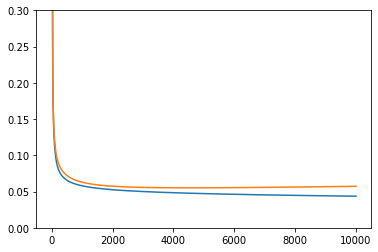

In [8]:
plt.ylim(0,0.3)
plt.plot(SL.losses)
plt.plot(SL.val_losses)

완만하게 떨어지는 것을 볼 수 있다. 

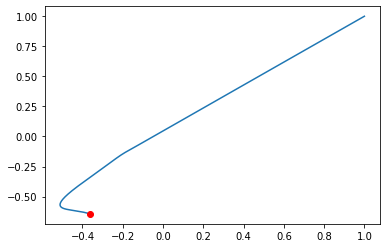

In [9]:
w2 = []
w3 = []
for w in SL.w_history:
    w2.append(w[2])
    w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')  # 저 빨간점. 손실값도 안정적으로 수렴

2 개의 층을 가진 신경망 구현

In [0]:
class DualLayer(SingleLayer_l1l2):
    def __init__(self, units=10, learning_rate=0.1, l1=0, l2=0):
        # unit 변수가 추가 (은닉층의 뉴런갯수 )
        self.units = units
        self.w1 = None
        self.b1 = None
        self.w2 = None
        self.b2 = None
        self.a1 = None
        self.losses = []
        self.val_losses = []
        self.lr = learning_rate
        self.l1 = l1
        self.l2 = l2

    def forpass(self, x):
        z1 = np.dot(x, self.w1) + self.b1  # 첫 번째 층 
        self.a1 = self.activation(z1)
        z2 = np.dot(self.a1, self.w2) +self.b2  # 두 번째 층
        return z2

    def backprop(self, x, error):
        m = len(x)  # 샘플 갯수
        w2_grad = np.dot(self.a1.T, error) / m   # 출력층의 가중치와 절편에 대한 그레이디언트 계산
        b2_grad = np.sum(error) / m
        error_to_hidden = np.dot(error, self.w2.T) * self.a1 * (1- self.a1)
        w1_grad = np.dot(x.T, error_to_hidden) / m
        b1_grad = np.sum(error_to_hidden, axis=0) / m
        return w1_grad, b1_grad, w2_grad, b2_grad

    # fit 메서드 쪼개기
    def init_weight(self, n_feature):
        # 변수를 초기화
        self.w1 = np.ones((n_feature, self.units))
        self.b1 = np.zeros(self.units)
        self.w2 = np.ones((self.units, 1))
        self.b2 = 0

    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y = y.reshape(-1,1)  # 타겟을 열 벡터로 바꾼다.
        y_val=y_val.reshape(-1,1)
        m = len(x)
        self.init_weight(x.shape[1])  # 은닉층과 출력층의 가중치를 초기화
        for i in range(epochs): # 에포크 수 만큼 돌리기
            a = self.training(x, y, m)
            a = np.clip(a, 1e-10, 1-1e-10)
            loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
            self.losses.append((loss + self.reg_loss()) / m)
            self.updata_val_loss(x_val, y_val)

    def training(self, x, y, m):
        # 훈련하는 메서드
        z = self.forpass(x)
        a = self.activation(z)
        err = -(y - a)
        w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)  # 오차 역전파, 그라디언트 계산
        w1_grad += (self.l1*np.sign(self.w1) + self.l2*self.w1)/m
        w2_grad += (self.l1*np.sign(self.w2) + self.l2 * self.w2) / m
        # 절편 업데이트
        self.w1 -= self.lr*w1_grad
        self.w2 -= self.lr*w2_grad
        self.b1 -= self.lr*b1_grad 
        self.b2 -= self.lr*b2_grad
        return a

    def reg_loss(self):
        # 규제 적용하기
        return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

In [20]:
dl = DualLayer(l2 = 0.01)
dl.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=20000)
dl.score(x_val_scaled, y_val)  #평가, 기존과 비슷하다.

0.978021978021978

(0.0, 0.3)

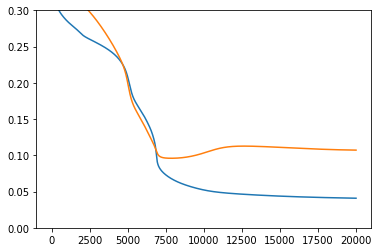

In [22]:
plt.plot(dl.losses)
plt.plot(dl.val_losses)
plt.ylim(0,0.3)

# 가중치를 렌덤하게 초기화하는 경우?


In [0]:
class RandomInit(DualLayer):
    def init_weight(self, n_feature):
        np.random.seed(42)
        self.w1 = np.random.normal(0, 1, (n_feature, self.units))  # 특성 갯수, 은닉층 크기
        self.b1 = np.zeros(self.units)
        self.w2 = np.random.normal(0,1, (self.units, 1))
        self.b2 = 0

ru = RandomInit(l2=0.01)
ru .fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=500)

(0.0, 0.3)

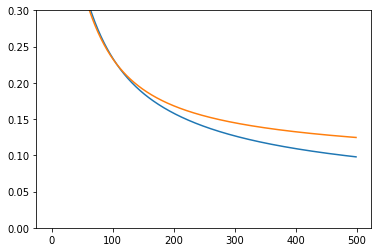

In [25]:
plt.plot(ru.losses)
plt.plot(ru.val_losses)
plt.ylim(0,0.3)

# 미니배치를 사용하여 훈련하기

In [0]:
class MiniBatch(RandomInit):
    def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0):
        # 미니 배치 사이즈를 정해줘야 한다. 
        super().__init__(units, learning_rate, l1, l2)  # 기존 상속하기 
        self.batch_size = batch_size

    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y = y.reshape(-1,1)  # 타겟을 열 벡터로 바꾼다.
        self.init_weight(x.shape[1])
        np.random.seed(42)  # 은닉층과 출력층의 가중치를 초기화
        for i in range(epochs): # 에포크 수 만큼 돌리기
            loss = 0
            # 제너레이터에서 반환한 미니배치 순환
            for x_batch, y_batch in self.gen_batch(x, y):
                y_batch = y_batch.reshape(-1,1)
                m = len(x_batch)
                a = self.training(x_batch, y_batch, m)
                a = np.clip(a, 1e-10, 1-1e-10)
                loss += np.sum(-(y_batch*np.log(a) + (1-y_batch)*np.log(1-a)))
            self.losses.append((loss + self.reg_loss()) / m)
            self.updata_val_loss(x_val, y_val)

    def gen_batch(self, x, y):
        length = len(x)
        bins = length // self.batch_size
        if length % self.batch_size:
            bins += 1
        indexes = np.random.permutation(np.arange(len(x)))  # 인덱스를 섞는다
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]  # 배치 사이즈 만큼 슬라이싱해서 반환합니다

In [27]:
# 배치 사이즈 32
batch32 = MiniBatch(l2=0.01, batch_size=32)
batch32.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=500)
batch32.score(x_val_scaled, y_val)

0.978021978021978

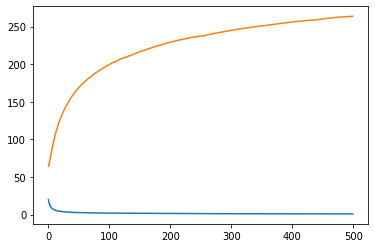

In [28]:
plt.plot(batch32.losses)
plt.plot(batch32.val_losses)


In [29]:
# 배치 사이즈 128
batch128 = MiniBatch(l2=0.01, batch_size=128)
batch128.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=500)
batch128.score(x_val_scaled, y_val)

0.978021978021978

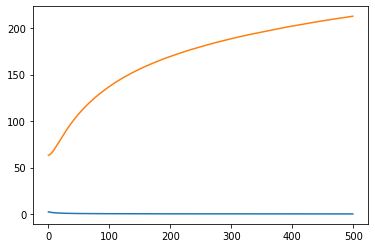

In [31]:
plt.plot(batch128.losses)
plt.plot(batch128.val_losses)


In [0]:
# 사이킷 런 사용하기

from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(10, ), activation='logistic',  solver='sgd', alpha=0.01, batch_size=32, learning_rate_init=0.1, max_iter=500)

In [33]:
mlp.fit(x_train_scaled, y_train)
mlp.score(x_val_scaled, y_val)

0.989010989010989